# HOME CREDIT SCORECARD MODEL
## FINAL PROJECT RAKAMIN PROJECT BASED INTERNSHIP

### BACKGROUND
Home Credit saat ini sedang menggunakan berbagai macam metode statistik dan Machine Learning untuk membuat prediksi skor kredit. Sekarang, kami meminta anda untuk membuka potensi maksimal dari data kami. Dengan melakukannya, kita dapat memastikan pelanggan yang mampu melakukan pelunasan tidak ditolak ketika melakukan pengajuan pinjaman, dan pinjaman datap diberikan dengan principal, maturity, dan repayment calendar yang akan memotivsi pelanggan untuk sukses.

#### Objective
- memastikan pelanggan yang mampu melakukan pelunasan tidak ditolak ketika melakukan pengajuan pinjaman 
- pinjaman dapat diberikan dengan principal, maturity, dan repayment calendar 
- Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)

### IMPORT LIBRARY

In [1]:
# standard libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.simplefilter('ignore')
import gc


# keras libraries
import tensorflow
from tensorflow import keras
from keras import models
from keras import layers
from keras import metrics
from keras.metrics import Precision
from tqdm.keras import TqdmCallback
from keras.backend import clear_session

# sklearn libraries
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# imblearn libraries
from imblearn.over_sampling import SMOTE

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt

### EDA

READ DATA

In [2]:
df_train = pd.read_csv('../Dataset/application_train.csv')
df_test = pd.read_csv('../Dataset/application_test.csv')
df_column_desc = pd.read_csv('../Dataset/HomeCredit_columns_description.csv', encoding='latin-1')
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


DESCRIBE

In [3]:
# Checknull
df_train.info()
print('Train Data Missing Value ',df_train.isnull().sum().sum())
print('Train Data Duplicate Value ',df_train.duplicated().sum())
# Print the count of columns
num_columns = df_train.shape[1]
print(f"Number of columns: {num_columns}")
# Print the count of rows
num_rows = df_train.shape[0]
print(f"Number of rows: {num_rows}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
Train Data Missing Value  9152465
Train Data Duplicate Value  0
Number of columns: 122
Number of rows: 307511


In [4]:
# Checknull
df_test.info()
print('Test Data Missing Value ',df_test.isnull().sum().sum())
print('Test Data Duplicate Value ',df_test.duplicated().sum())
# Print the count of columns
num_columns = df_test.shape[1]
print(f"Number of columns: {num_columns}")
# Print the count of rows
num_rows = df_test.shape[0]
print(f"Number of rows: {num_rows}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
Test Data Missing Value  1404419
Test Data Duplicate Value  0
Number of columns: 121
Number of rows: 48744


In [5]:
Column_Train = df_column_desc[df_column_desc['Table'] == 'application_{train|test}.csv']
column_train = Column_Train[['Row','Description']]
column_train

,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,TARGET,Target variable (1 - client with payment diffi...
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,CODE_GENDER,Gender of the client
4,FLAG_OWN_CAR,Flag if the client owns a car
...,...,...
117,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...
118,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...
119,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...
120,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...


Check if any innapropriate input

In [6]:
#Unique Of Each Column
for column in df_train.columns:
    unique_values = df_train[column].unique()
    print(f"Unique values in column '{column}':")
    print(unique_values)
    print()

Unique values in column 'SK_ID_CURR':
[100002 100003 100004 ... 456253 456254 456255]

Unique values in column 'TARGET':
[1 0]

Unique values in column 'NAME_CONTRACT_TYPE':
['Cash loans' 'Revolving loans']

Unique values in column 'CODE_GENDER':
['M' 'F' 'XNA']

Unique values in column 'FLAG_OWN_CAR':
['N' 'Y']

Unique values in column 'FLAG_OWN_REALTY':
['Y' 'N']

Unique values in column 'CNT_CHILDREN':
[ 0  1  2  3  4  7  5  6  8  9 11 12 10 19 14]

Unique values in column 'AMT_INCOME_TOTAL':
[202500.  270000.   67500.  ...  96768.  546250.5 113062.5]

Unique values in column 'AMT_CREDIT':
[ 406597.5 1293502.5  135000.  ...  181989.   743863.5 1391130. ]

Unique values in column 'AMT_ANNUITY':
[24700.5 35698.5  6750.  ... 71986.5 58770.  77809.5]

Unique values in column 'AMT_GOODS_PRICE':
[ 351000.  1129500.   135000.  ...  453465.   143977.5  743863.5]

Unique values in column 'NAME_TYPE_SUITE':
['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group

DATA VISUALIZATION

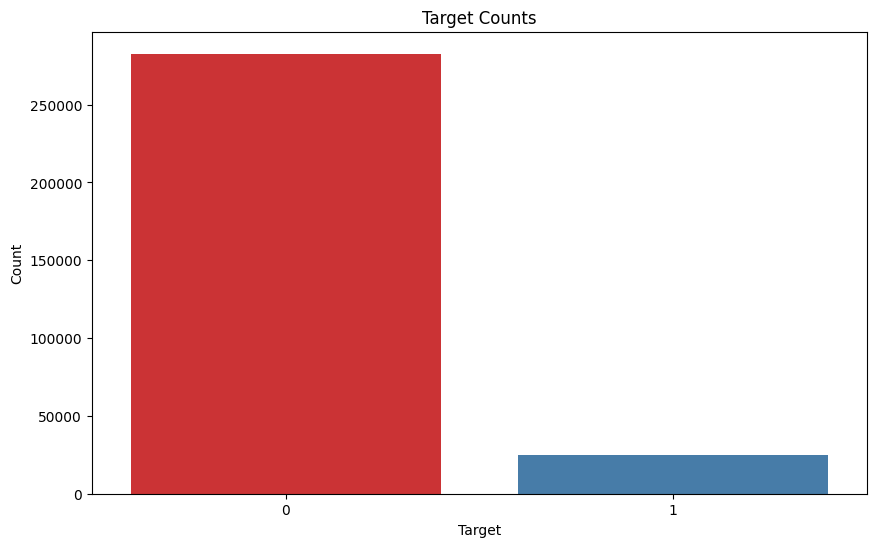

Target Counts:
0    282686
1     24825
Name: TARGET, dtype: int64


In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x='TARGET',data=df_train,palette='Set1')
plt.title("Target Counts")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()
targetcounts = df_train['TARGET'].value_counts()

# Display the counts
print("Target Counts:")
print(targetcounts)

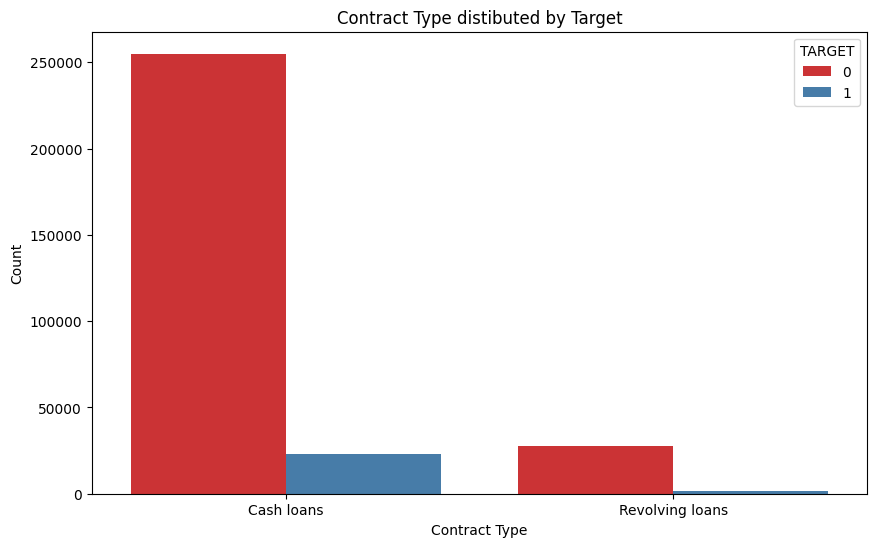

Target Counts:
Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64


In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x='NAME_CONTRACT_TYPE',data=df_train, hue="TARGET",palette='Set1')
plt.title('Contract Type distibuted by Target')
plt.xlabel("Contract Type")
plt.ylabel("Count")
plt.show()
val_count = df_train['NAME_CONTRACT_TYPE'].value_counts()

# Display the counts
print("Target Counts:")
print(val_count)

Gender Counts:
F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64


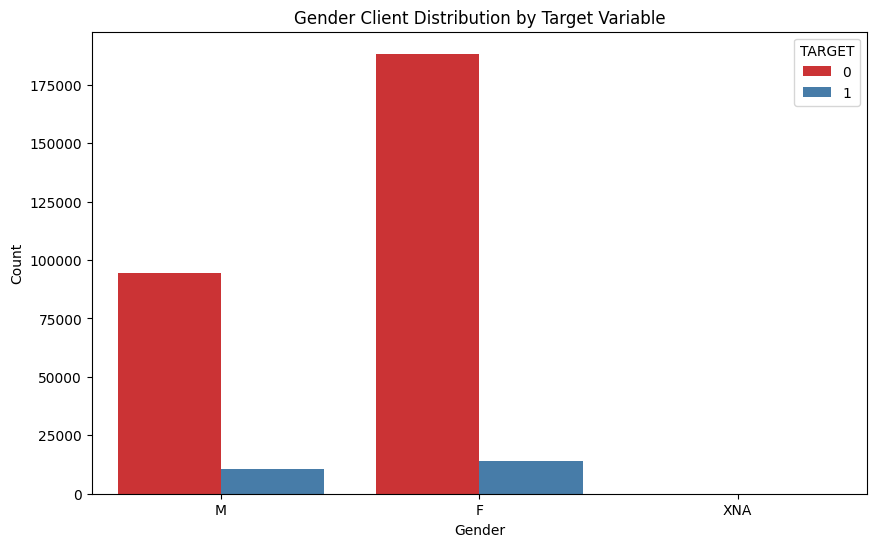

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_train, x='CODE_GENDER', hue='TARGET', palette='Set1')
plt.title('Gender Client Distribution by Target Variable')
plt.xlabel("Gender")
plt.ylabel("Count")
# Count occurrences of each gender
gender_counts = df_train['CODE_GENDER'].value_counts()

# Display the counts
print("Gender Counts:")
print(gender_counts)

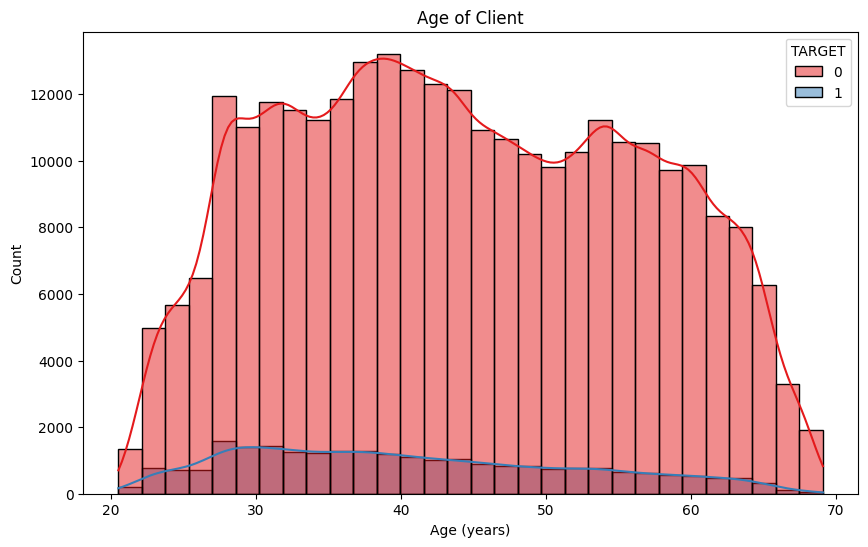

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x= (df_train['DAYS_BIRTH']/-365), bins=30, kde=True, hue='TARGET', palette='Set1')
plt.title('Age of Client')
plt.xlabel("Age (years)")
plt.ylabel("Count")
plt.show()

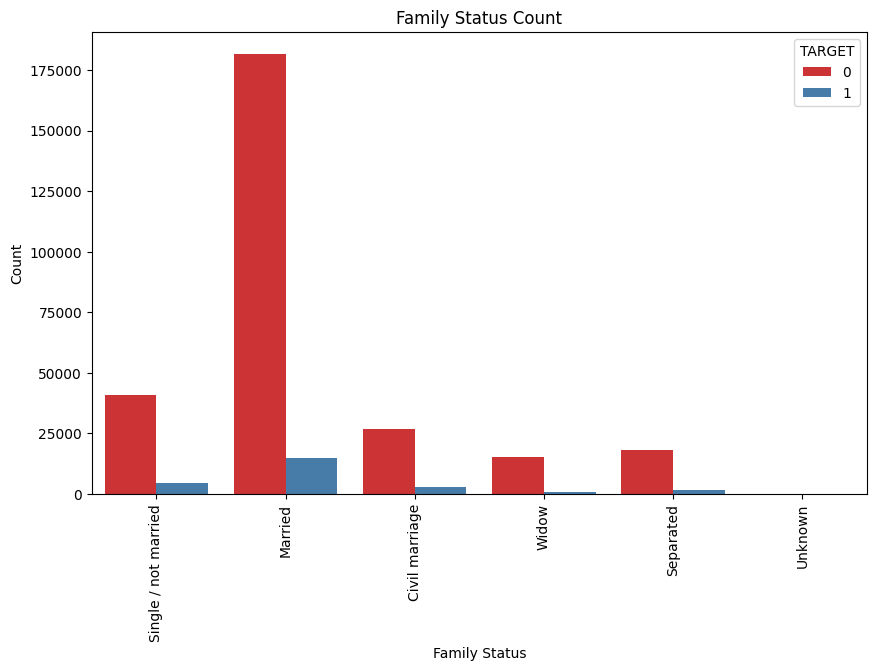

Gender Counts:
Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64


In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_train, x='NAME_FAMILY_STATUS', hue='TARGET', palette='Set1')
plt.title("Family Status Count")
plt.xlabel("Family Status")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()
statusf_count = df_train['NAME_FAMILY_STATUS'].value_counts()
# Display the counts
print("Gender Counts:")
print(statusf_count)

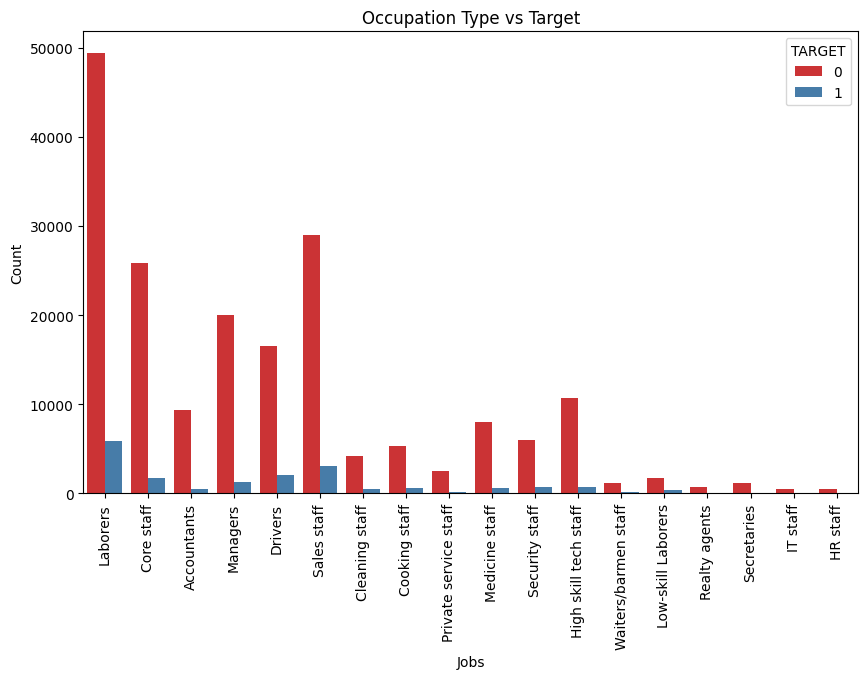

In [12]:
plt.figure(figsize=(10, 6))
sns.countplot(x='OCCUPATION_TYPE',hue='TARGET',data=df_train,palette='Set1')
plt.title("Occupation Type vs Target")
plt.xlabel("Jobs")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

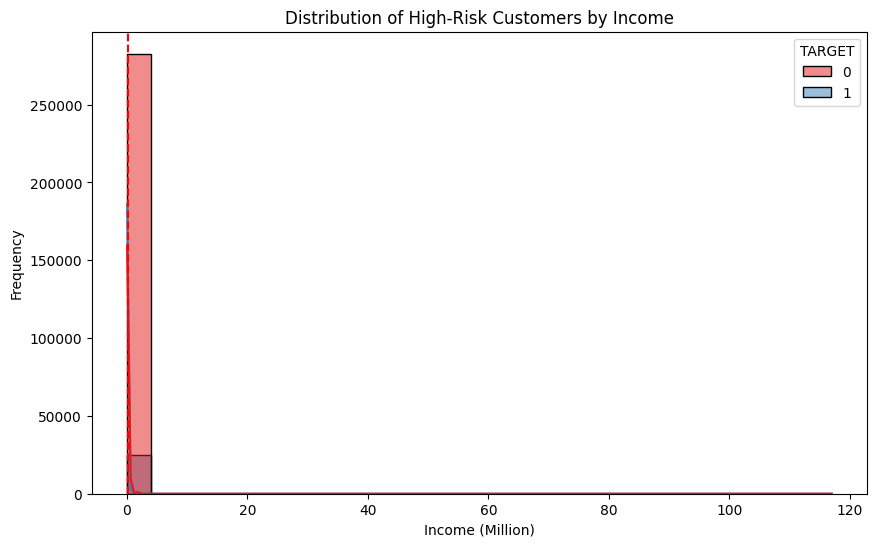

In [13]:
# Visualize the distribution of high-risk customers by income
plt.figure(figsize=(10, 6))
sns.histplot(x=df_train['AMT_INCOME_TOTAL']/1000000, bins=30, kde=True, hue='TARGET', data=df_train, palette='Set1')
plt.axvline(x=df_train[df_train['TARGET']==1]['AMT_INCOME_TOTAL'].mean()/1000000, color='red', linestyle='dashed', label='Mean Income of High-Risk Customers')
plt.title("Distribution of High-Risk Customers by Income")
plt.xlabel("Income (Million)")
plt.ylabel("Frequency")
plt.show()

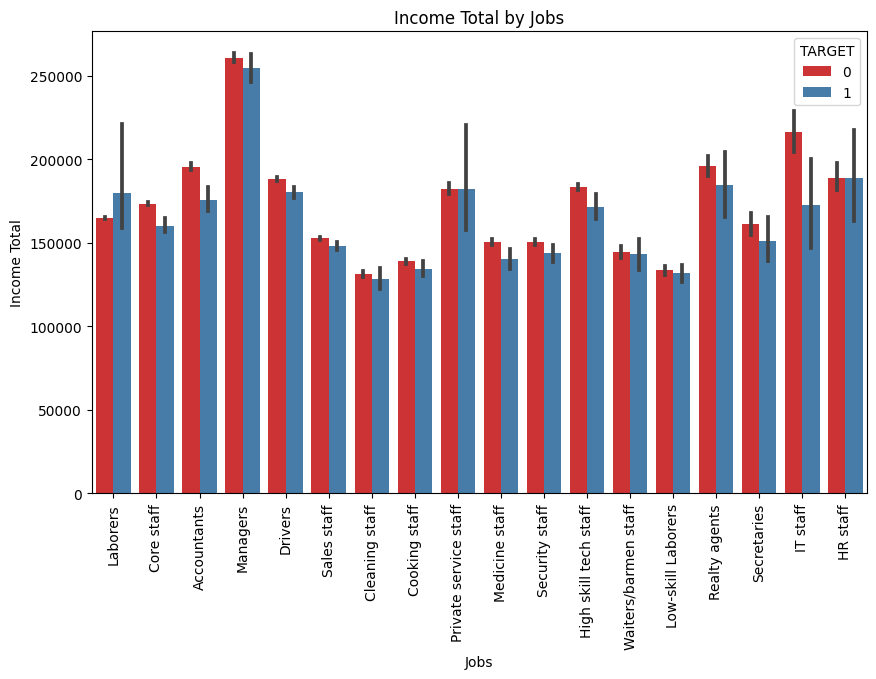

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(x='OCCUPATION_TYPE',y='AMT_INCOME_TOTAL',data=df_train, hue="TARGET", palette='Set1')
plt.title("Income Total by Jobs")
plt.xlabel("Jobs")
plt.ylabel("Income Total")
plt.xticks(rotation=90)
plt.show()

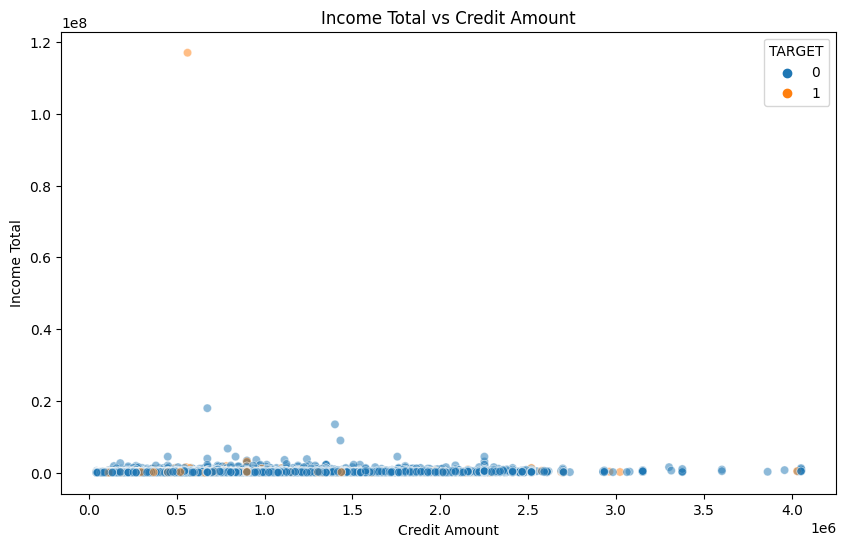

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AMT_CREDIT', y='AMT_INCOME_TOTAL', data=df_train, hue='TARGET', alpha=0.5)
plt.title("Income Total vs Credit Amount")
plt.xlabel("Credit Amount")
plt.ylabel("Income Total")
plt.show()

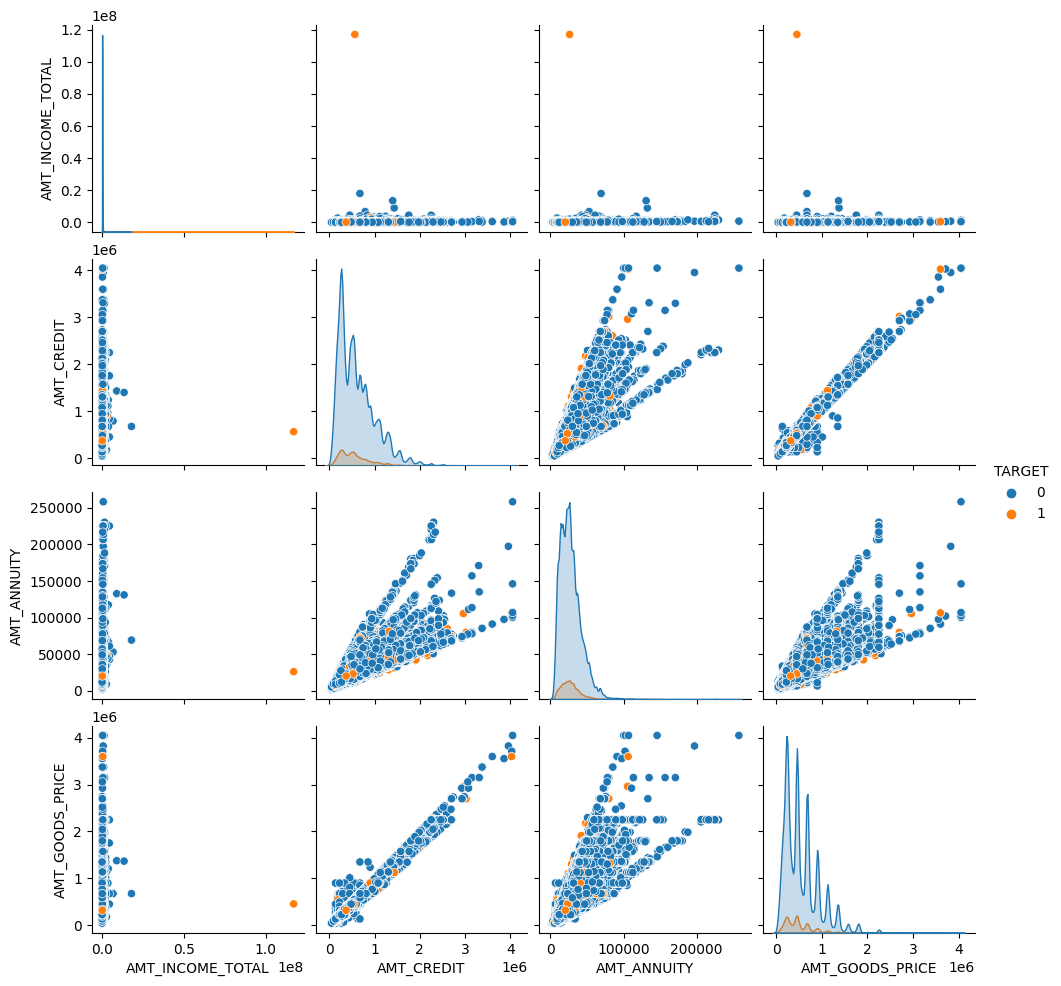

In [16]:
# SHOW CORRELATION BETWEEN TARGET to Income, Credit, Annuity, Goods Price
columns_to_visualize = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',]
sns.pairplot(df_train[columns_to_visualize + ['TARGET']], hue='TARGET')
plt.show()

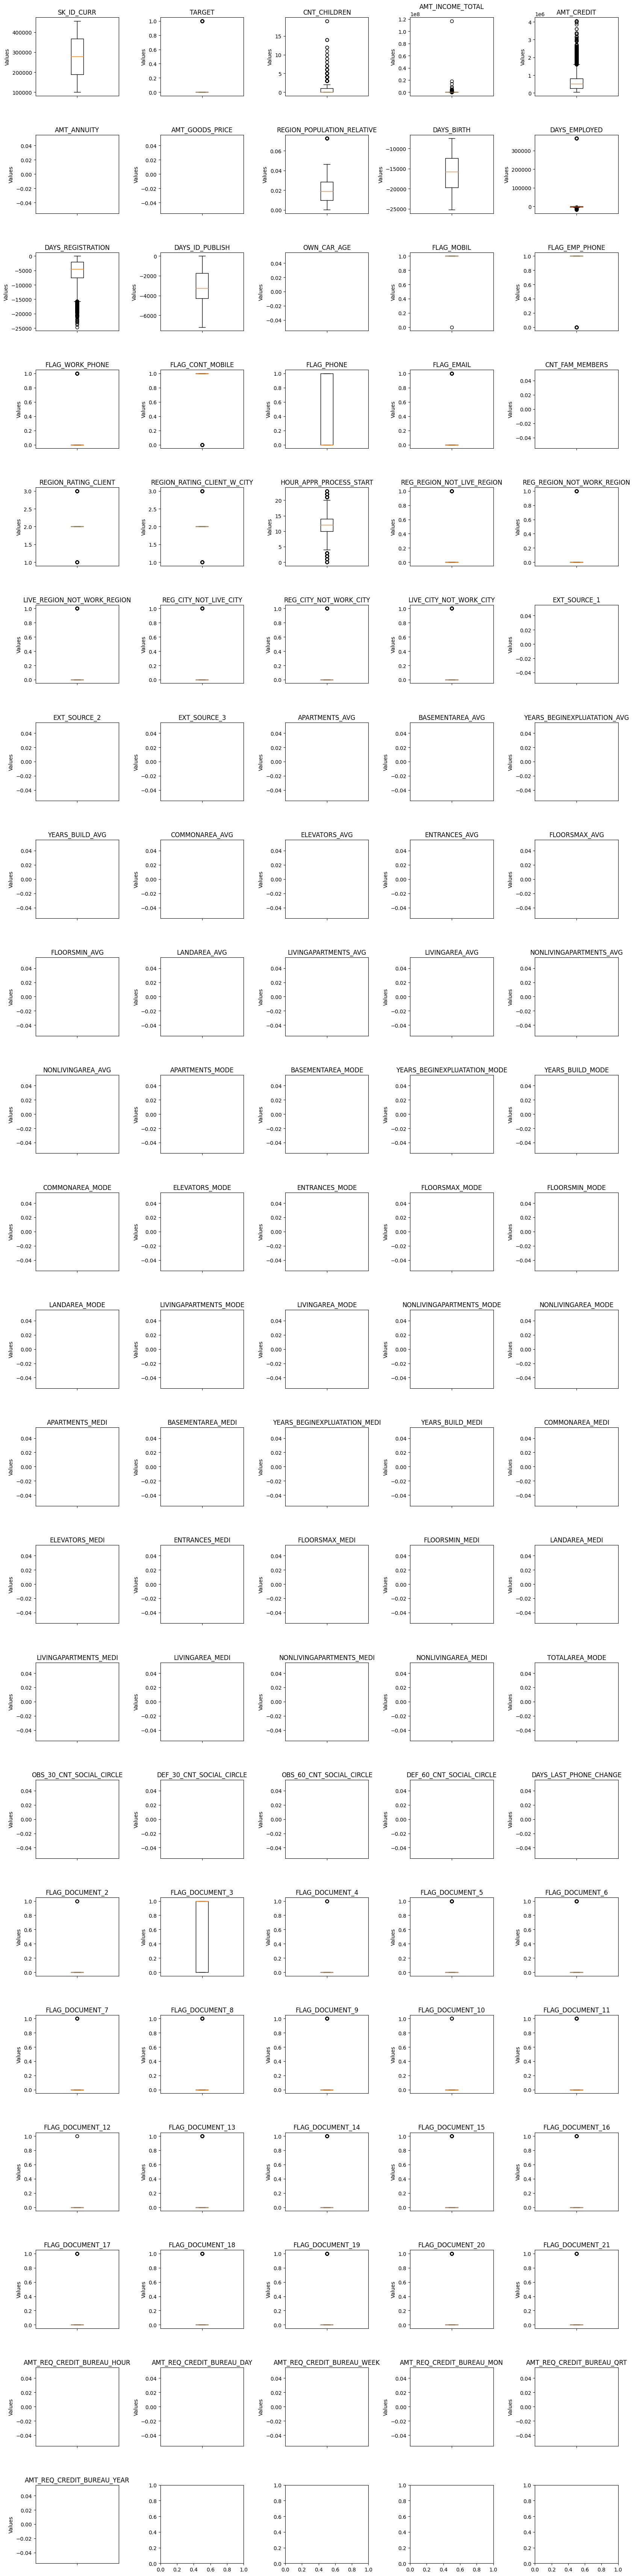

In [17]:
# CHECK _OUTLIERS_ IN NUMERIC COLUMNS
# Get numeric columns
numeric_columns = df_train.select_dtypes(include=['int64', 'float64']).columns

# Calculate the number of subplots needed based on the number of numeric columns
num_subplots = len(numeric_columns)
num_cols_per_subplot = 5
num_rows = (num_subplots - 1) // num_cols_per_subplot + 1

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols_per_subplot, figsize=(20, 4 * num_rows))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
axs = axs.ravel()

# Loop through numeric columns and create box plots
for i, col in enumerate(numeric_columns):
    axs[i].boxplot(df_train[col])
    axs[i].set_title(col)
    axs[i].set_xticklabels([])
    axs[i].set_ylabel('Values')

# Show plots
plt.show()




### PREPROCESSING TRAIN DATA & TEST DATA

#### FUCTION

In [18]:
# handling
# outlier
def outlier(df):
  Q1 = df.quantile(0.25)
  Q3 = df.quantile(0.75)
  IQR = Q3-Q1
  df_final = df[~((df<(Q1-(1.5*IQR))) | (df>(Q3+(1.5*IQR))))]
  return df_final

#### CLEANSING

Replace NULL

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [20]:
print('Count Null Train',df_train.isna().sum().sum())
print('Count Null Test',df_test.isna().sum().sum())

Count Null Train 9152465
Count Null Test 1404419


In [21]:
## ** PREPROCESSING NULL VALUES TRAIN**
#DECLARE NUMERICAL AND CATEGORICAL COLUMNS
cat_col_train = df_train.select_dtypes(include=['object']).columns
num_col_train = df_train.select_dtypes(include=['int64', 'float64']).columns

#REPLACE NaN WITH MODE, when the data is categorical
# Impute missing values for categorical columns with mode
categorical_imputer = SimpleImputer(strategy='most_frequent')
df_train[cat_col_train] = categorical_imputer.fit_transform(df_train[cat_col_train])

#REPLACE NaN WITH MEAN, when the data is numerical
# Impute missing values for numeric columns with median
numeric_imputer = SimpleImputer(strategy='median')
df_train[num_col_train] = numeric_imputer.fit_transform(df_train[num_col_train])

## ** PREPROCESSING NULL VALUES TRAIN**
#DECLARE NUMERICAL AND CATEGORICAL COLUMNS
cat_col_test = df_test.select_dtypes(include=['object']).columns
num_col_test = df_test.select_dtypes(include=['int64', 'float64']).columns

#REPLACE NaN WITH MODE, when the data is categorical
# Impute missing values for categorical columns with mode
categorical_imputer = SimpleImputer(strategy='most_frequent')
df_test[cat_col_test] = categorical_imputer.fit_transform(df_test[cat_col_test])

#REPLACE NaN WITH MEAN, when the data is numerical
# Impute missing values for numeric columns with median
numeric_imputer = SimpleImputer(strategy='median')
df_test[num_col_test] = numeric_imputer.fit_transform(df_test[num_col_test])

In [22]:
print('Count Null Train',df_train.isna().sum().sum())
print('Count Null Test',df_test.isna().sum().sum())

Count Null Train 0
Count Null Test 0


In [23]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002.0,1.0,Cash loans,M,N,Y,0.0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003.0,0.0,Cash loans,F,N,N,0.0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004.0,0.0,Revolving loans,M,Y,Y,0.0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006.0,0.0,Cash loans,F,N,Y,0.0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,100007.0,0.0,Cash loans,M,N,Y,0.0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001.0,Cash loans,F,N,Y,0.0,135000.0,568800.0,20560.5,450000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005.0,Cash loans,M,N,Y,0.0,99000.0,222768.0,17370.0,180000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013.0,Cash loans,M,Y,Y,0.0,202500.0,663264.0,69777.0,630000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028.0,Cash loans,F,N,Y,2.0,315000.0,1575000.0,49018.5,1575000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038.0,Cash loans,M,Y,N,1.0,180000.0,625500.0,32067.0,625500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


Drop Duplicates

In [25]:
# Check If Duplicates Exist
print('Count Duplicates Train',df_train.duplicated().sum())
print('Count Duplicates Test',df_test.duplicated().sum())

Count Duplicates Train 0
Count Duplicates Test 0


Because the gender have 3 entity instead 2, we should drop entity XNA

In [26]:
# Filter out data Not M or F
valid_genders = ['M', 'F']
df_train = df_train[df_train['CODE_GENDER'].isin(valid_genders)]
df_test = df_test[df_test['CODE_GENDER'].isin(valid_genders)]

# Drop rows with NaN values from both training and test DataFrames
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)


#### ENCODING

Check Column with Categorical Data

In [27]:
# SHOW COLUMN WITH CATEGORICAL DATA
categorical_columns = df_train.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"Column: {col}")
    print(f"Unique values: {df_train[col].unique()}")


Column: NAME_CONTRACT_TYPE
Unique values: ['Cash loans' 'Revolving loans']
Column: CODE_GENDER
Unique values: ['M' 'F']
Column: FLAG_OWN_CAR
Unique values: ['N' 'Y']
Column: FLAG_OWN_REALTY
Unique values: ['Y' 'N']
Column: NAME_TYPE_SUITE
Unique values: ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' 'Other_B'
 'Group of people']
Column: NAME_INCOME_TYPE
Unique values: ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
Column: NAME_EDUCATION_TYPE
Unique values: ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
Column: NAME_FAMILY_STATUS
Unique values: ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
Column: NAME_HOUSING_TYPE
Unique values: ['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
Column: OCCUPATION_TYPE
Unique values: ['Laborers' 'Core 

In [28]:
# SHOW COLUMN WITH NUMERICAL DATA
numeric_columns = df_train.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_columns:
    print(f"Column: {col}")


Column: SK_ID_CURR
Column: TARGET
Column: CNT_CHILDREN
Column: AMT_INCOME_TOTAL
Column: AMT_CREDIT
Column: AMT_ANNUITY
Column: AMT_GOODS_PRICE
Column: REGION_POPULATION_RELATIVE
Column: DAYS_BIRTH
Column: DAYS_EMPLOYED
Column: DAYS_REGISTRATION
Column: DAYS_ID_PUBLISH
Column: OWN_CAR_AGE
Column: FLAG_MOBIL
Column: FLAG_EMP_PHONE
Column: FLAG_WORK_PHONE
Column: FLAG_CONT_MOBILE
Column: FLAG_PHONE
Column: FLAG_EMAIL
Column: CNT_FAM_MEMBERS
Column: REGION_RATING_CLIENT
Column: REGION_RATING_CLIENT_W_CITY
Column: HOUR_APPR_PROCESS_START
Column: REG_REGION_NOT_LIVE_REGION
Column: REG_REGION_NOT_WORK_REGION
Column: LIVE_REGION_NOT_WORK_REGION
Column: REG_CITY_NOT_LIVE_CITY
Column: REG_CITY_NOT_WORK_CITY
Column: LIVE_CITY_NOT_WORK_CITY
Column: EXT_SOURCE_1
Column: EXT_SOURCE_2
Column: EXT_SOURCE_3
Column: APARTMENTS_AVG
Column: BASEMENTAREA_AVG
Column: YEARS_BEGINEXPLUATATION_AVG
Column: YEARS_BUILD_AVG
Column: COMMONAREA_AVG
Column: ELEVATORS_AVG
Column: ENTRANCES_AVG
Column: FLOORSMAX_AVG
C

Replace Cat to Num

In [29]:
#DF_TRAIN ENCODED
df_train_en = df_train.copy()

In [30]:
# Replace categorical values with numerical labels (0, 1, 2)
for col in categorical_columns:
    df_train_en[col] = pd.Categorical(df_train_en[col])
    df_train_en[col] = df_train_en[col].cat.codes

# Columns to exclude from scaling
columns_to_exclude = ['SK_ID_CURR', 'TARGET']

# Apply StandardScaler to numeric columns (excluding specific columns)
scaler = StandardScaler()
for col in numeric_columns:
    if col not in columns_to_exclude:
        df_train_en[col] = scaler.fit_transform(df_train_en[[col]])

# Now 'df_train_en' contains numerical labels for categorical columns and normalized numeric columns, excluding specified columns from scaling


In [31]:
df_test_en = df_test.copy()

In [32]:
# Replace categorical values with numerical labels (0, 1, 2)
for col in categorical_columns:
    df_test_en[col] = pd.Categorical(df_test_en[col])
    df_test_en[col] = df_test_en[col].cat.codes

# Columns to exclude from scaling
columns_to_exclude = ['SK_ID_CURR', 'TARGET']

# Apply StandardScaler to numeric columns (excluding specific columns)
scaler = StandardScaler()
for col in numeric_columns:
    if col not in columns_to_exclude:
        df_test_en[col] = scaler.fit_transform(df_test_en[[col]])

# Now 'df_test_en' contains numerical labels for categorical columns and normalized numeric columns, excluding specified columns from scaling


In [33]:
df_train_en.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002.0,1.0,0,1,0,1,-0.577534,0.142129,-0.478099,-0.166149,...,-0.090535,-0.024402,-0.022529,-0.018305,-0.070988,-0.058766,-0.155839,-0.269942,-0.308618,-0.440916
1,100003.0,0.0,0,0,0,0,-0.577534,0.426790,1.725436,0.592674,...,-0.090535,-0.024402,-0.022529,-0.018305,-0.070988,-0.058766,-0.155839,-0.269942,-0.308618,-1.007325
2,100004.0,0.0,1,1,1,1,-0.577534,-0.427192,-1.152889,-1.404670,...,-0.090535,-0.024402,-0.022529,-0.018305,-0.070988,-0.058766,-0.155839,-0.269942,-0.308618,-1.007325
3,100006.0,0.0,0,0,0,1,-0.577534,-0.142532,-0.711433,0.177867,...,-0.090535,-0.024402,-0.022529,-0.018305,-0.070988,-0.058766,-0.155839,-0.269942,-0.308618,-0.440916
4,100007.0,0.0,0,1,0,1,-0.577534,-0.199464,-0.213740,-0.361754,...,-0.090535,-0.024402,-0.022529,-0.018305,-0.070988,-0.058766,-0.155839,-0.269942,-0.308618,-1.007325


In [34]:
df_test_en.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001.0,0,0,0,1,-0.559988,-0.427809,0.142475,-0.553580,-0.037477,...,-0.039517,0.0,0.0,0.0,-0.042538,-0.036585,-0.048265,-0.078421,-0.711321,-1.153865
1,100005.0,0,1,0,1,-0.559988,-0.782413,-0.804537,-0.752831,-0.839362,...,-0.039517,0.0,0.0,0.0,-0.042538,-0.036585,-0.048265,-0.078421,-0.711321,0.589324
2,100013.0,0,1,1,1,-0.559988,0.237075,0.401002,2.520066,0.497113,...,-0.039517,0.0,0.0,0.0,-0.042538,-0.036585,-0.048265,-0.078421,0.773588,1.170387
3,100028.0,0,0,0,1,2.260729,1.345214,2.896221,1.223666,3.303709,...,-0.039517,0.0,0.0,0.0,-0.042538,-0.036585,-0.048265,-0.078421,-0.711321,0.589324
4,100038.0,0,1,1,0,0.850370,0.015447,0.297651,0.165019,0.483748,...,-0.039517,0.0,0.0,0.0,-0.042538,-0.036585,-0.048265,-0.078421,-0.711321,0.008261


Handle Outliers

In [35]:
# Columns to apply the outlier function to
columns_to_process = ['AMT_INCOME_TOTAL', 'DAYS_EMPLOYED']

# Isolate the columns you want to process
selected_columns = df_train_en[columns_to_process]

# Apply the outlier function to selected columns
processed_columns = outlier(selected_columns)

# Replace the original columns with the processed columns
df_train_en[columns_to_process] = processed_columns
df_train_en.fillna(method='bfill',inplace=True)

#### HANDLING IMBALANCE DATA

Before we come further to feature selection we should handling the imbalance of the dataset

In [36]:
# Split the data into features (X_train) and target (y_train)
X_train = df_train_en.drop(['TARGET'], axis=1)
y_train = df_train_en['TARGET']

# Show Count of Target Variable
print('Target Variable Count:')
print(y_train.value_counts())

Target Variable Count:
0.0    282682
1.0     24825
Name: TARGET, dtype: int64


In [37]:
# Apply SMOTE to balance the class distribution
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print('After applying SMOTE:')
print(y_train_resampled.value_counts())

After applying SMOTE:
1.0    282682
0.0    282682
Name: TARGET, dtype: int64


#### FEATURE SELECTION

After we handling the imbalance data we need to check correlation 120 column to target, and pick which one had better correlation using SelectKBest f Classif

In [38]:
df_test_en.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001.0,0,0,0,1,-0.559988,-0.427809,0.142475,-0.553580,-0.037477,...,-0.039517,0.0,0.0,0.0,-0.042538,-0.036585,-0.048265,-0.078421,-0.711321,-1.153865
1,100005.0,0,1,0,1,-0.559988,-0.782413,-0.804537,-0.752831,-0.839362,...,-0.039517,0.0,0.0,0.0,-0.042538,-0.036585,-0.048265,-0.078421,-0.711321,0.589324
2,100013.0,0,1,1,1,-0.559988,0.237075,0.401002,2.520066,0.497113,...,-0.039517,0.0,0.0,0.0,-0.042538,-0.036585,-0.048265,-0.078421,0.773588,1.170387
3,100028.0,0,0,0,1,2.260729,1.345214,2.896221,1.223666,3.303709,...,-0.039517,0.0,0.0,0.0,-0.042538,-0.036585,-0.048265,-0.078421,-0.711321,0.589324
4,100038.0,0,1,1,0,0.850370,0.015447,0.297651,0.165019,0.483748,...,-0.039517,0.0,0.0,0.0,-0.042538,-0.036585,-0.048265,-0.078421,-0.711321,0.008261


In [39]:
# Number of features to select
num_features_to_select = 60

# Initialize the SelectKBest feature selector using f_classif score function
selector = SelectKBest(score_func=f_classif, k=num_features_to_select)

# Fit the selector on the resampled training data and transform the features
X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)

# Transform the test data using the same selector
X_test_selected = selector.transform(df_test_en)  # Drop 'SK_ID_CURR'

# Create DataFrames with selected features for both training and testing data
selected_features_train = df_train_en.drop(['TARGET'], axis=1).columns[selector.get_support()]
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_features_train)

selected_features_test = df_train_en.drop(['TARGET'], axis=1).columns[selector.get_support()]
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_features_test)
X_test_selected_df['SK_ID_CURR'] = df_test_en['SK_ID_CURR']

# Append the 'SK_ID_CURR' and target columns back to the selected training data
X_train_selected_df['SK_ID_CURR'] = df_train_en['SK_ID_CURR']
X_train_selected_df['TARGET'] = y_train_resampled

# Now you have DataFrames with selected features, 'SK_ID_CURR', and the target column
X_train_selected_df.head()


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_CREDIT,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,REGION_POPULATION_RELATIVE,...,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,SK_ID_CURR,TARGET
0,0.0,1.0,0.0,1.0,-0.478099,-0.507239,7.0,4.0,3.0,-0.149444,...,-0.902011,5.0,0.0,4.164042,5.254315,-0.206989,0.639051,-0.31074,100002.0,1.0
1,0.0,0.0,0.0,0.0,1.725436,1.600865,4.0,1.0,1.0,-1.252739,...,-0.187817,0.0,0.0,-0.320487,-0.275675,0.163109,0.639051,-0.31074,100003.0,0.0
2,1.0,1.0,1.0,1.0,-1.152889,-1.092146,7.0,4.0,3.0,-0.783441,...,-0.220682,4.0,0.0,-0.320487,-0.275675,0.178832,-1.564821,-0.31074,100004.0,0.0
3,0.0,0.0,0.0,1.0,-0.711433,-0.653466,7.0,4.0,0.0,-0.928980,...,-0.220682,4.0,0.0,-0.320487,-0.275675,0.418307,0.639051,-0.31074,100006.0,0.0
4,0.0,1.0,0.0,1.0,-0.213740,-0.068558,7.0,4.0,3.0,0.563577,...,-0.220682,4.0,0.0,-0.320487,-0.275675,-0.173124,-1.564821,-0.31074,100007.0,0.0


In [40]:
X_test_selected_df.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_CREDIT,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,REGION_POPULATION_RELATIVE,...,FONDKAPREMONT_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,SK_ID_CURR
0,0.0,0.0,0.0,1.0,0.142475,-0.037477,6.0,1.0,1.0,-0.164654,...,2.0,-0.610590,5.0,0.0,-0.279167,-0.250398,-0.753470,0.520828,-0.309618,100001.0
1,0.0,1.0,0.0,1.0,-0.804537,-0.839362,6.0,4.0,1.0,1.009586,...,2.0,-0.233614,4.0,0.0,-0.279167,-0.250398,1.226251,0.520828,-0.309618,100005.0
2,0.0,1.0,1.0,1.0,0.401002,0.497113,6.0,1.0,1.0,-0.147258,...,2.0,-0.233614,4.0,0.0,-0.279167,-0.250398,0.252319,-1.920019,-0.309618,100013.0
3,0.0,0.0,0.0,1.0,2.896221,3.303709,6.0,4.0,1.0,0.358078,...,2.0,3.348266,4.0,0.0,-0.279167,-0.250398,-0.827425,0.520828,-0.309618,100028.0
4,0.0,1.0,1.0,0.0,0.297651,0.483748,6.0,4.0,1.0,-0.775825,...,2.0,-0.233614,4.0,0.0,-0.279167,-0.250398,0.292141,0.520828,-0.309618,100038.0


#### SPLIT DATA TRAIN & VAL

In [41]:
# Split the resampled training data into train and validation sets
X_train_selected_split, X_val_selected, y_train_split, y_val = train_test_split(
    X_train_selected, y_train_resampled, test_size=0.2, random_state=42
)
# record stats
print(f"Training Records = {X_train_selected_split.shape[0]} ; Validation Record {X_val_selected.shape[0]} ; Testing Record {X_test_selected.shape[0]}")


Training Records = 452291 ; Validation Record 113073 ; Testing Record 48744


### MODEL TRAINING

Logistic Regression

In [42]:
# #Hyperparameter Tuning
# # Hyperparameter tuning using GridSearchCV
# param_grid = {
#     'C': [0.1, 0.5, 1],
#     'penalty': ['l1', 'l2'],
#     'solver': ['liblinear', 'lbfgs'],
# }

# grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5)
# grid_search.fit(X_train_selected_split, y_train_split)
# # Print the best parameters found by GridSearchCV
# print("Best Parameters:", grid_search.best_params_)
# best_logreg = grid_search.best_estimator_

# # Make predictions on the test data
# y_test_pred = best_logreg.predict(X_test_selected)


In [43]:
# Train a LogisticRegression model on the selected features
logreg_classifier = LogisticRegression(random_state=42,verbose=1, n_jobs=-1, max_iter=200, C=0.5, penalty='l1', solver='liblinear', class_weight='balanced')
logreg_classifier.fit(X_train_selected_split, y_train_split)

# Make predictions on the test data
y_test_pred = logreg_classifier.predict(X_test_selected)

[LibLinear]

In [44]:
# Make predictions on the validation set
y_val_pred = logreg_classifier.predict(X_val_selected)

# Calculate accuracy, precision, recall, and F1 score on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print(f"Validation Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Validation Accuracy: 0.76
Precision: 0.76
Recall: 0.78
F1 Score: 0.77


Confusion Matrix:
[[41989 14360]
 [12388 44336]]


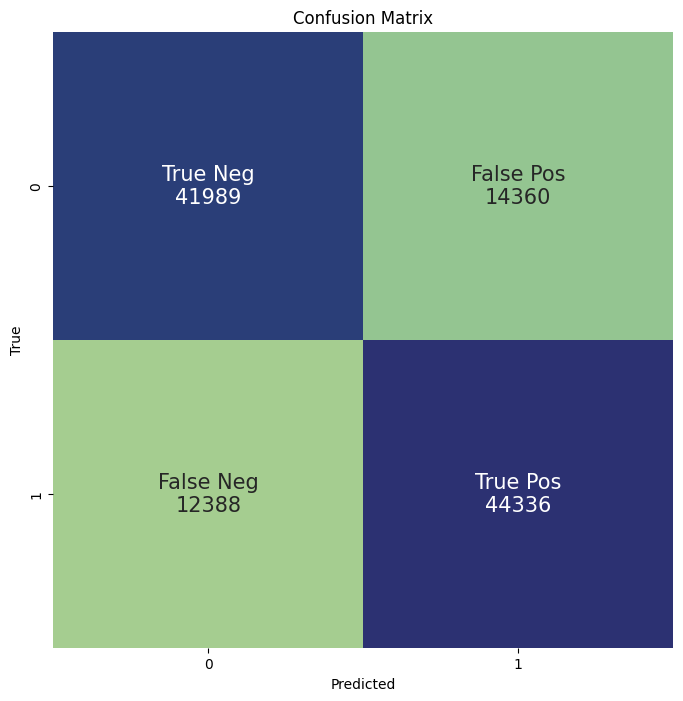

In [45]:
# Display confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix as a heatmap
plt.figure(figsize=(8, 8))
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(conf_matrix, annot=labels, cmap='crest', cbar=False, fmt='', annot_kws={"size": 15})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [46]:
# Define class names if applicable
class_names = ["Class 0", "Class 1"]

# Display classification report
class_report = classification_report(y_val, y_val_pred, target_names=class_names)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.77      0.75      0.76     56349
     Class 1       0.76      0.78      0.77     56724

    accuracy                           0.76    113073
   macro avg       0.76      0.76      0.76    113073
weighted avg       0.76      0.76      0.76    113073



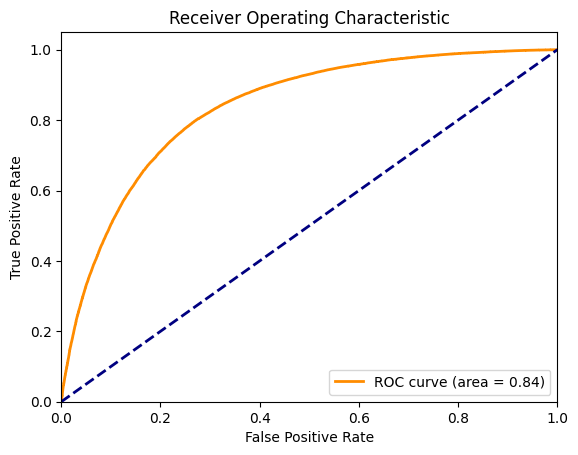

In [47]:
# y_scores = log.decision_function(X_test_selected)
y_scores = logreg_classifier.predict_proba(X_val_selected)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Random Forrest

In [48]:
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# # Initialize the RandomForestClassifier
# rf_classifier = RandomForestClassifier(random_state=42)

# # Perform GridSearchCV for hyperparameter tuning
# grid_search = GridSearchCV(rf_classifier, param_grid, cv=5)
# grid_search.fit(X_train_selected_split, y_train_split)

# # Get the best RandomForestClassifier model from the grid search
# best_rf_classifier = grid_search.best_estimator_

# # Make predictions on the test data using the best model
# y_test_pred = best_rf_classifier.predict(X_test_selected)

In [49]:
# Train a RandomForestClassifier on the selected features
rf_classifier = RandomForestClassifier(random_state=42,verbose=1,n_jobs=-1,n_estimators=200, max_features='log2', class_weight='balanced')
rf_classifier.fit(X_train_selected_split, y_train_split)

# Make predictions on the test data
y_test_pred = rf_classifier.predict(X_test_selected)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.2s finished


In [50]:
# Make predictions on the validation set
y_val_pred = rf_classifier.predict(X_val_selected)
# Calculate accuracy, precision, recall, and F1 score on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    2.4s finished


In [51]:
print(f"Validation Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Validation Accuracy: 0.95
Precision: 1.00
Recall: 0.91
F1 Score: 0.95


Confusion Matrix:
[[56165   184]
 [ 5235 51489]]


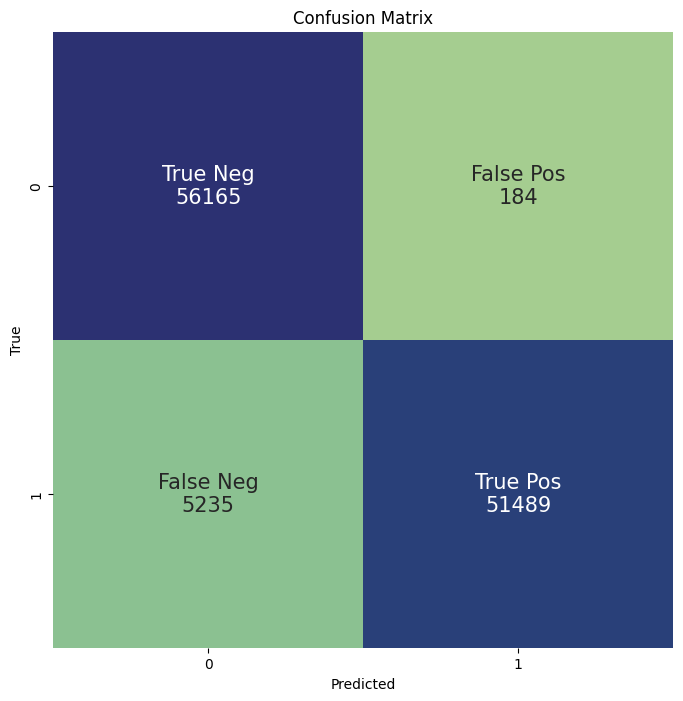

In [52]:
# Display confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix as a heatmap
plt.figure(figsize=(8, 8))
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(conf_matrix, annot=labels, cmap='crest', cbar=False, fmt='', annot_kws={"size": 15})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [53]:
# Define class names if applicable
class_names = ["Class 0", "Class 1"]

# Display classification report
class_report = classification_report(y_val, y_val_pred, target_names=class_names)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.91      1.00      0.95     56349
     Class 1       1.00      0.91      0.95     56724

    accuracy                           0.95    113073
   macro avg       0.96      0.95      0.95    113073
weighted avg       0.96      0.95      0.95    113073



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    2.5s finished


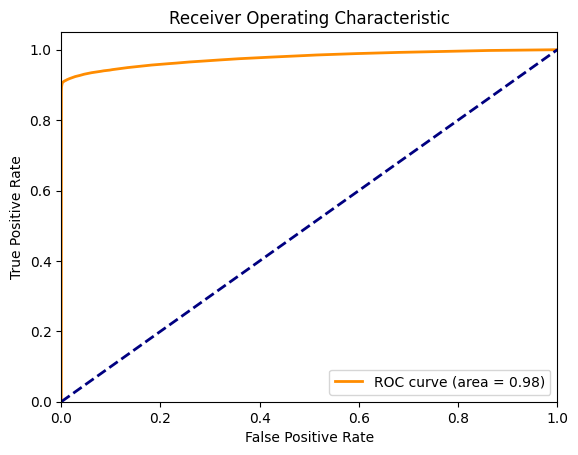

In [54]:
# y_scores = log.decision_function(X_test_selected)
y_scores = rf_classifier.predict_proba(X_val_selected)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

KERAS MLP - NEURAL NETWORK

In [55]:
input_shape = X_train_selected_split.shape[1]
nodes1 = np.ceil(2 * input_shape / 4).astype(int)                         
nodes2 = np.ceil(2 * input_shape / 3).astype(int)
nodes3 = np.ceil(2 * input_shape / 4).astype(int)                         
batch_size = np.ceil(len(X_train_selected_split) / 128).astype(int)

print('input_shape: ', input_shape)
print('nodes1: ', nodes1)
print('nodes2: ', nodes2)  
print('nodes3: ', nodes3)
print('batch_size: ', batch_size)

input_shape:  60
nodes1:  30
nodes2:  40
nodes3:  30
batch_size:  3534


In [56]:
# define model params
input_shape = X_train_selected_split.shape[1]
nodes1 = np.ceil(2 * input_shape / 4).astype(int)                         
nodes2 = np.ceil(2 * input_shape / 3).astype(int)
nodes3 = np.ceil(2 * input_shape / 4).astype(int)                         
batch_size = np.ceil(len(X_train_selected_split) / 128).astype(int)                                     

# build model
model = models.Sequential()
# input layer
model.add(layers.Dense(
                        batch_size
                       ,input_shape=(input_shape,)
                       ,name='input_layer'
                       ,activation='selu'))
# hidden layer
model.add(layers.Dense(
                        nodes1
                        ,name='hidden_nodes1'
                       ,activation='selu'))
# hidden layer
model.add(layers.Dense(
                        nodes2
                        ,name='hidden_nodes2'
                       ,activation='selu'))
# hidden layer
model.add(layers.Dense(
                        nodes3
                        ,name='hidden_nodes3'
                       ,activation='selu'))
# dropout layer
model.add(layers.Dropout(0.5))

# output layer
model.add(layers.Dense(
                        1  # Binary classification
                        ,name='output_layer'
                       ,activation='sigmoid'))

# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Dense)         (None, 3534)              215574    
                                                                 
 hidden_nodes1 (Dense)       (None, 30)                106050    
                                                                 
 hidden_nodes2 (Dense)       (None, 40)                1240      
                                                                 
 hidden_nodes3 (Dense)       (None, 30)                1230      
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 31        
                                                                 
Total params: 324,125
Trainable params: 324,125
Non-trai

In [57]:
# model fit params
epoch = 200

# garbage collect, incase we're re-running the model to get the best fit
gc.collect()
    
# reset model , incase we're re-running the model to get the best fit
clear_session()

# fit the keras model on the dataset
hist = model.fit(X_train_selected_split
                  ,y_train_split
                  ,epochs = epoch
                  ,batch_size=batch_size
                  ,shuffle=True
                  ,validation_data=(X_val_selected, y_val)
                  ,verbose=0
                  ,callbacks=[TqdmCallback(verbose=0)]
          )


 22%|██▏       | 44/200 [11:04<41:15, 15.87s/epoch, loss=0.238, accuracy=0.904, val_loss=0.233, val_accuracy=0.904]

KeyboardInterrupt: 

In [ ]:
# Calculate metrics on validation data using the trained model
y_val_pred = model.predict(X_val_selected)
y_val_pred_class = (y_val_pred > 0.5).astype(int)  # Convert probability scores to class predictions

accuracy = accuracy_score(y_val, y_val_pred_class)
precision = precision_score(y_val, y_val_pred_class)
recall = recall_score(y_val, y_val_pred_class)
f1 = f1_score(y_val, y_val_pred_class)

print(f"Validation Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

3534/3534 [==============================] - 6s 2ms/step
Validation Accuracy: 0.92
Precision: 0.97
Recall: 0.88
F1 Score: 0.92


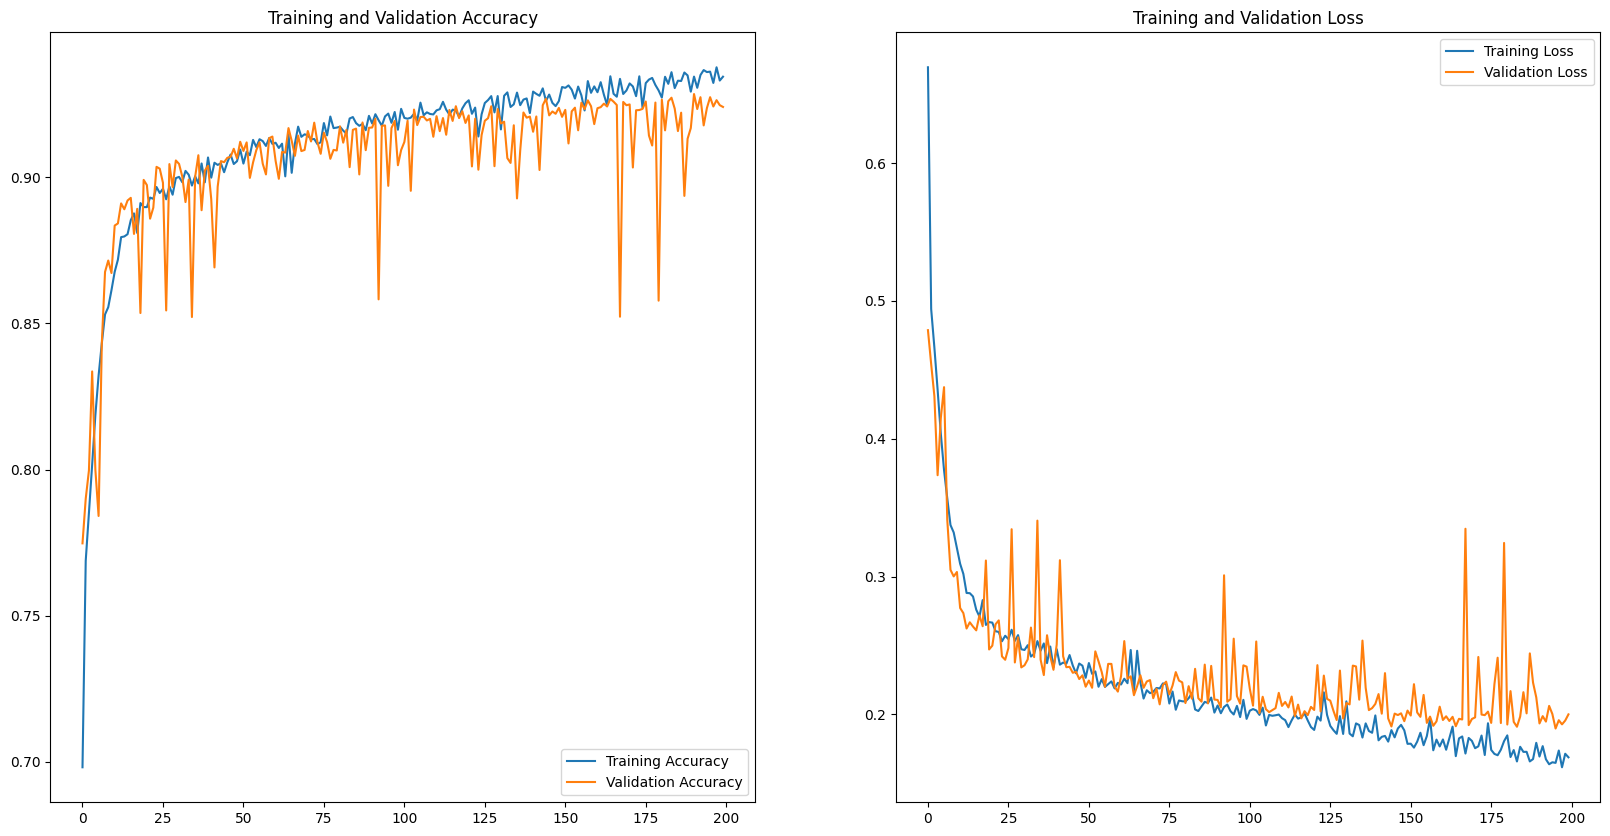

In [ ]:
# visualize training results
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Confusion Matrix:
[[54827  1522]
 [ 7057 49667]]


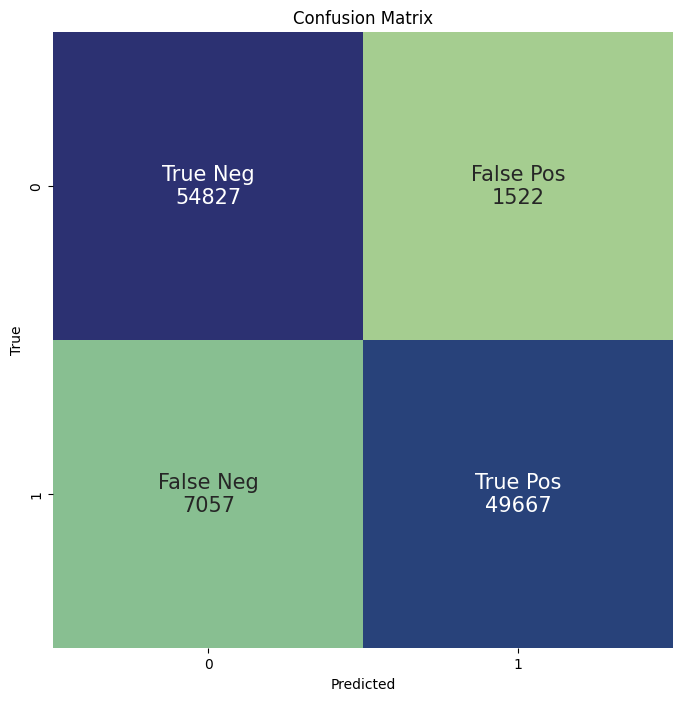

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred_class)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix as a heatmap
plt.figure(figsize=(8, 8))
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(conf_matrix, annot=labels, cmap='crest', cbar=False, fmt='', annot_kws={"size": 15})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Define class names if applicable
class_names = ["Class 0", "Class 1"]

# Display classification report
class_report = classification_report(y_val, y_val_pred_class, target_names=class_names)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.89      0.97      0.93     56349
     Class 1       0.97      0.88      0.92     56724

    accuracy                           0.92    113073
   macro avg       0.93      0.92      0.92    113073
weighted avg       0.93      0.92      0.92    113073



3534/3534 [==============================] - 6s 2ms/step


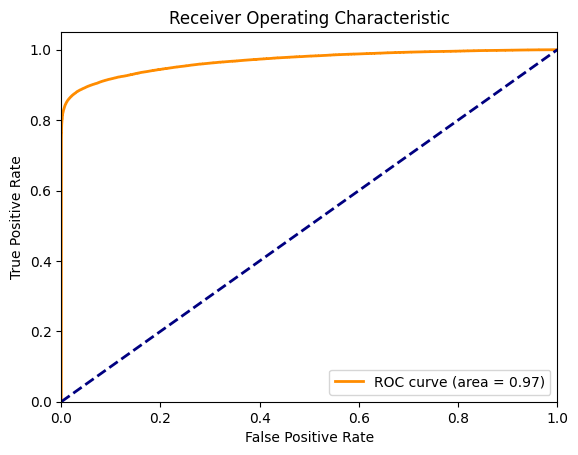

In [ ]:
# Calculate predicted probabilities using the trained model
y_scores = model.predict(X_val_selected)

# For binary classification, we take the probability of the positive class
y_scores_positive = y_scores.flatten()  # Flatten the y_scores array

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_val, y_scores_positive)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### BUSINESS RECOMENDATION

In [ ]:
# Extract 'SK_ID_CURR' from X_test_selected_df
id = X_test_selected_df['SK_ID_CURR']

# Drop 'SK_ID_CURR' from X_test_selected_df
X_test_selected_df.drop(columns=['SK_ID_CURR'], inplace=True)

# Use the model for business recommendations
# Assuming threshold for considering a customer as high-risk is 0.5
threshold = 0.5
y_prob = rf_classifier.predict_proba(X_test_selected_df)[:, 1]

# Create a DataFrame with 'SK_ID_CURR' and predicted probabilities
output_df = pd.DataFrame({'SK_ID_CURR': id, 'PREDICT': y_prob})
save_csv = output_df.to_csv('Predict_Scorecard.csv', index=False)
# Filter high-risk customers based on the threshold
# high_risk_customers = output_df[output_df['PREDICT'] >= threshold]
high_risk_customers = output_df
# Print the high-risk customers DataFrame
high_risk_customers


KeyError: 'SK_ID_CURR'

In [ ]:
# Combine high_risk_customers with original data_test using 'SK_ID_CURR' as key
# combined_df = pd.merge(df_test, high_risk_customers, on='SK_ID_CURR', how='left')
combined_df = pd.merge(df_test, output_df, on='SK_ID_CURR', how='left')
# Print the combined DataFrame
combined_df


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,PREDICT
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.91
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,0.95
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0,0.89
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,0.90
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.81
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.94
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0,0.83
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.79


In [ ]:
combined_df.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,PREDICT
count,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.000000,...,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,48744.000000
mean,277796.676350,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,0.021226,-16068.084605,67485.366322,-4967.652716,...,0.0,0.0,0.0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769,0.906060
std,103169.547296,0.709047,1.015226e+05,3.653970e+05,16016.368315,3.367102e+05,0.014428,4325.900393,144348.507136,3552.612035,...,0.0,0.0,0.0,0.046373,0.046132,0.054037,0.110924,0.693305,1.838873,0.087976
min,100001.000000,0.000000,2.694150e+04,4.500000e+04,2295.000000,4.500000e+04,0.000253,-25195.000000,-17463.000000,-23722.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.290000
25%,188557.750000,0.000000,1.125000e+05,2.606400e+05,17973.000000,2.250000e+05,0.010006,-19637.000000,-2910.000000,-7459.250000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.860000
50%,277549.000000,0.000000,1.575000e+05,4.500000e+05,26199.000000,3.960000e+05,0.018850,-15785.000000,-1293.000000,-4490.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.930000
75%,367555.500000,1.000000,2.250000e+05,6.750000e+05,37390.500000,6.300000e+05,0.028663,-12496.000000,-296.000000,-1901.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.970000
max,456250.000000,20.000000,4.410000e+06,2.245500e+06,180576.000000,2.245500e+06,0.072508,-7338.000000,365243.000000,0.000000,...,0.0,0.0,0.0,2.000000,2.000000,2.000000,6.000000,7.000000,17.000000,1.000000


In [ ]:
# Classify the target into categories
def classify_target(value):
    if value >= 0.75:
        return "High Risk"
    elif value >= 0.50:
        return "Medium Risk"
    else:
        return "Low Risk"

combined_df["Target_Category"] = combined_df['PREDICT'].apply(classify_target)

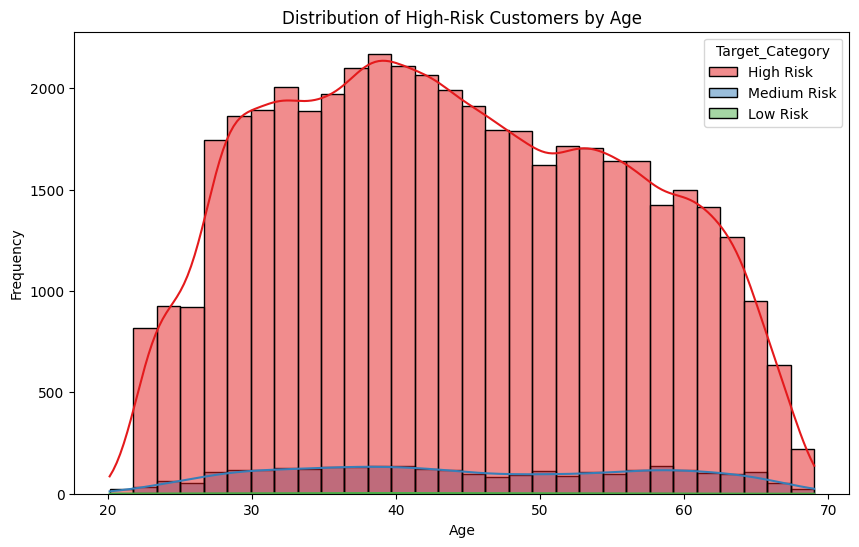

mean low risk age:  40.22079496968336
mean medium risk age:  45.04226171154043
mean high risk age:  43.96132324531329


In [ ]:
# Visualize the distribution of high-risk customers by age
plt.figure(figsize=(10, 6))
sns.histplot(data=combined_df, x= (combined_df['DAYS_BIRTH']/-365), bins=30, kde=True, hue='Target_Category', palette='Set1')
plt.title("Distribution of High-Risk Customers by Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()
print("mean low risk age: ", (combined_df[combined_df['Target_Category'] == 'Low Risk']['DAYS_BIRTH']/-365).mean())
print('mean medium risk age: ', (combined_df[combined_df['Target_Category'] == 'Medium Risk']['DAYS_BIRTH']/-365).mean())
print('mean high risk age: ', (combined_df[combined_df['Target_Category'] == 'High Risk']['DAYS_BIRTH']/-365).mean())

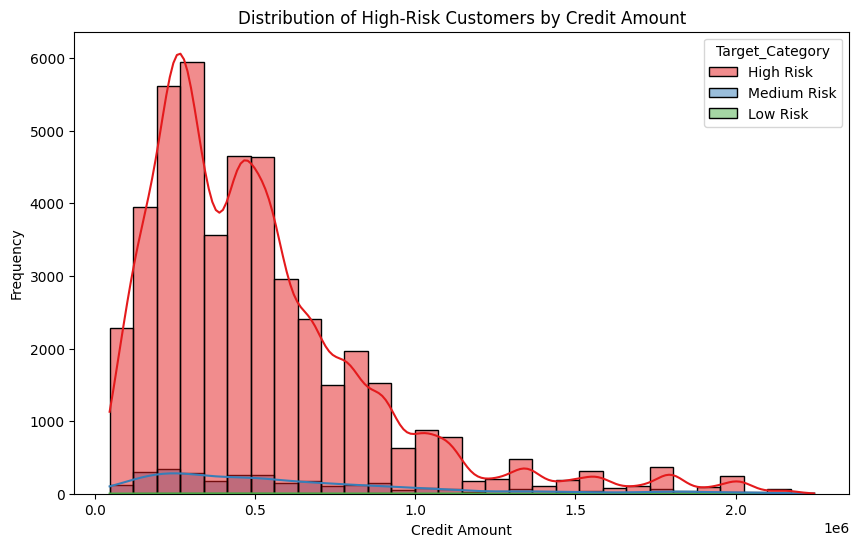

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(x='AMT_CREDIT', bins=30, kde=True, data=combined_df, hue='Target_Category', palette='Set1')
plt.title("Distribution of High-Risk Customers by Credit Amount")
plt.xlabel("Credit Amount")
plt.ylabel("Frequency")
plt.show()


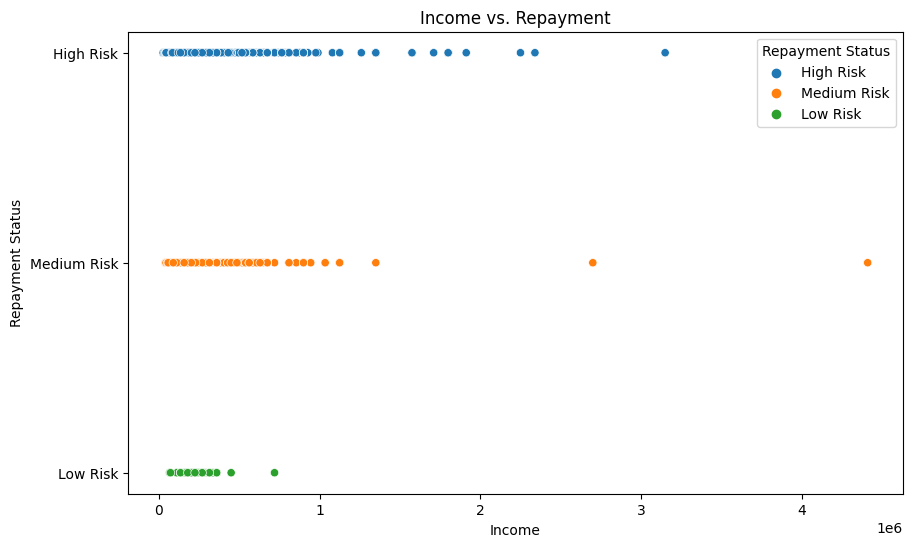

In [ ]:
# Income vs. Repayment
plt.figure(figsize=(10, 6))
sns.scatterplot(x="AMT_INCOME_TOTAL", y="Target_Category", hue="Target_Category", data=combined_df)
plt.title("Income vs. Repayment")
plt.xlabel("Income")
plt.ylabel("Repayment Status")
plt.legend(title="Repayment Status")
plt.show()

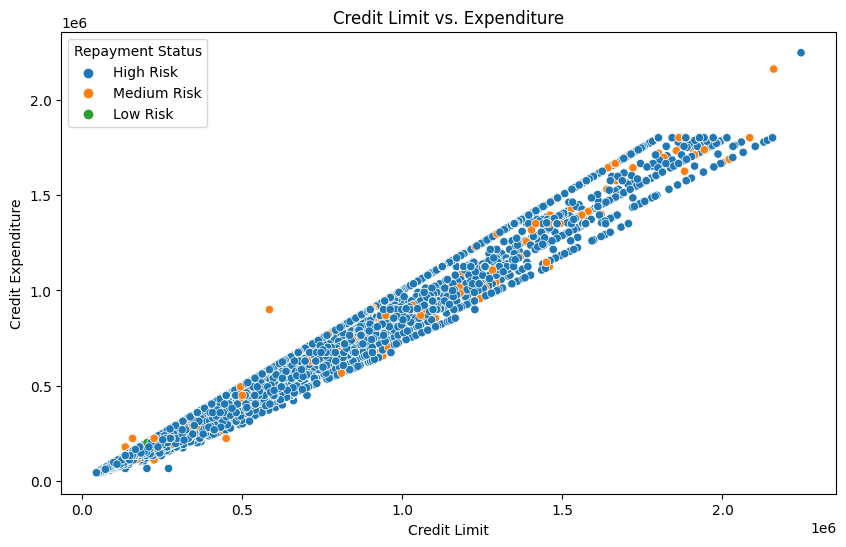

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="AMT_CREDIT", y="AMT_GOODS_PRICE", hue="Target_Category", data=combined_df)
plt.title("Credit Limit vs. Expenditure")
plt.xlabel("Credit Limit")
plt.ylabel("Credit Expenditure")
plt.legend(title="Repayment Status")
plt.show()

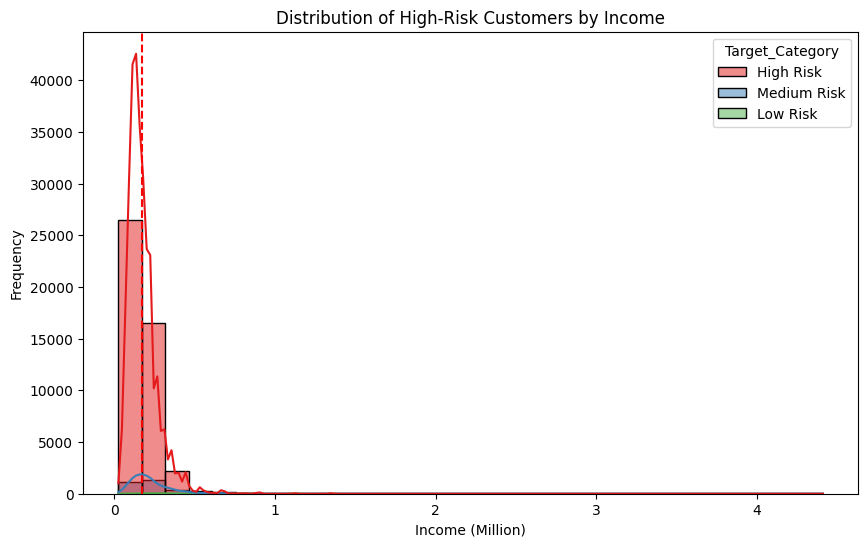

Mean Income of High-Risk Customers: 0.18 Million
Or 175336.48 Thousand
Percentage of High-Risk Customers: 93.06% With 0.75 Threshold


In [ ]:
# Visualize the distribution of high-risk customers by income
plt.figure(figsize=(10, 6))
sns.histplot(x=combined_df['AMT_INCOME_TOTAL']/1000000, bins=30, kde=True, hue='Target_Category', data=combined_df, palette='Set1')
plt.axvline(x=combined_df[combined_df['PREDICT']>0.75]['AMT_INCOME_TOTAL'].mean()/1000000, color='red', linestyle='dashed', label='Mean Income of High-Risk Customers')
plt.title("Distribution of High-Risk Customers by Income")
plt.xlabel("Income (Million)")
plt.ylabel("Frequency")
plt.show()

high_risk_mean_income_million = combined_df[combined_df['PREDICT'] > 0.75]['AMT_INCOME_TOTAL'].mean() / 1000000
high_risk_mean_income_thousand = combined_df[combined_df['PREDICT'] > 0.75]['AMT_INCOME_TOTAL'].mean() / 1
print('Mean Income of High-Risk Customers: {:.2f} Million'.format(high_risk_mean_income_million))
print('Or {:.2f} Thousand'.format(high_risk_mean_income_thousand))
print(f"Percentage of High-Risk Customers: {round(combined_df[combined_df['PREDICT']>0.75]['AMT_INCOME_TOTAL'].count()/combined_df['AMT_INCOME_TOTAL'].count()*100, 2)}% With 0.75 Threshold")

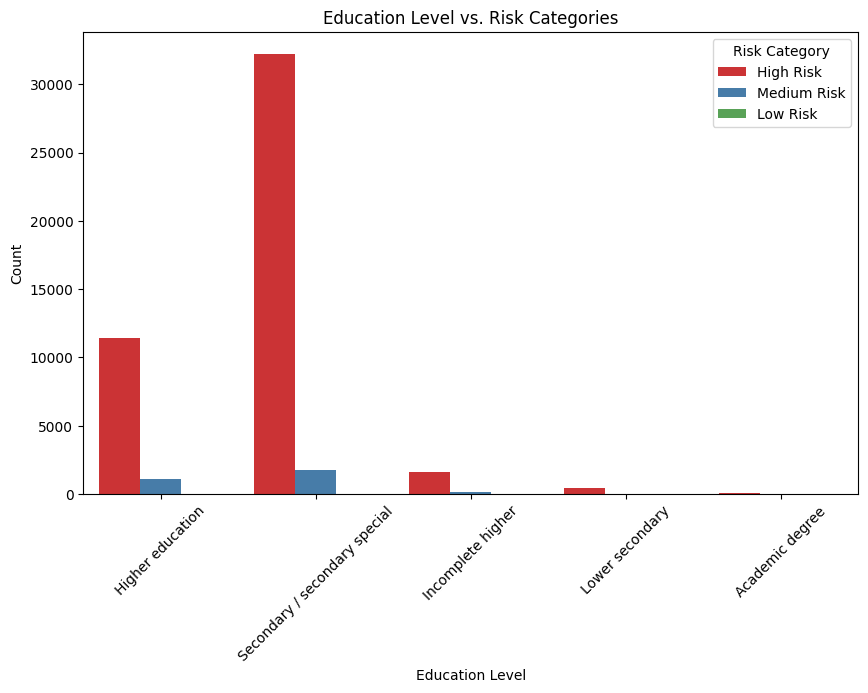

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x="NAME_EDUCATION_TYPE", hue="Target_Category", data=combined_df, palette="Set1")
plt.title("Education Level vs. Risk Categories")
plt.xlabel("Education Level")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Risk Category")
plt.show()


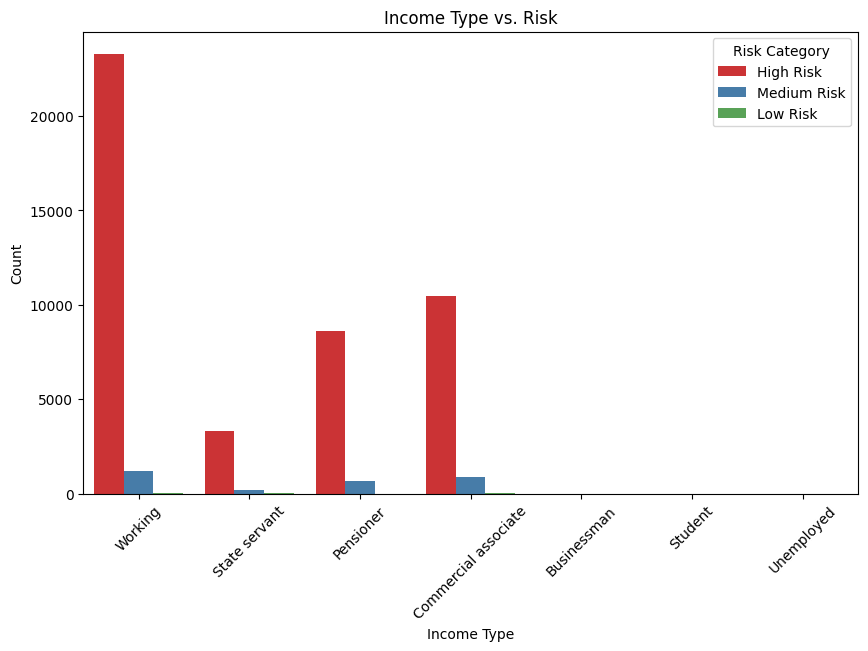

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x="NAME_INCOME_TYPE", hue="Target_Category", data=combined_df , palette="Set1")
plt.title("Income Type vs. Risk")
plt.xlabel("Income Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Risk Category")
plt.show()


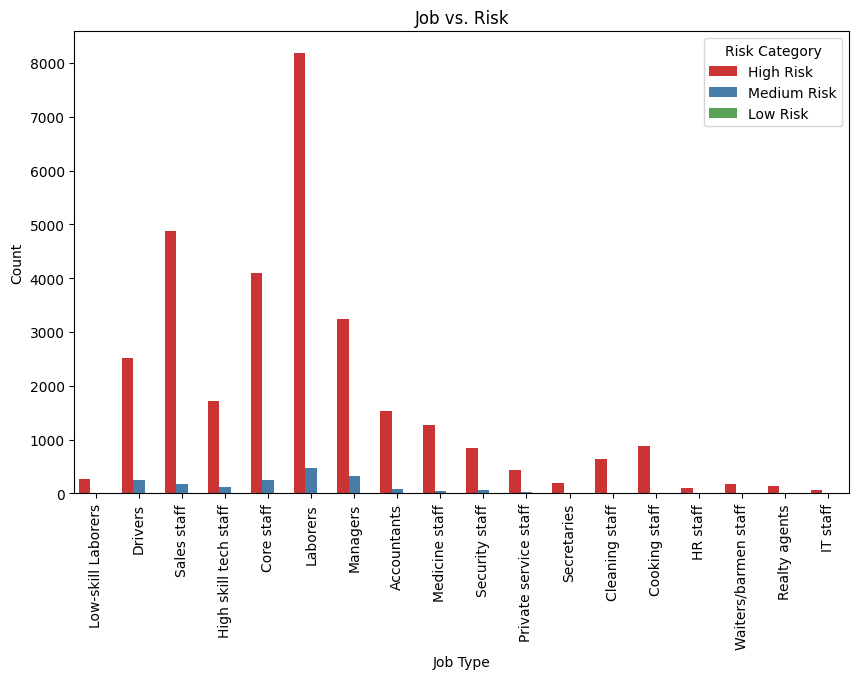

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='OCCUPATION_TYPE',hue='Target_Category',data=combined_df,palette='Set1')
plt.title("Job vs. Risk")
plt.xlabel("Job Type")
plt.ylabel("Count")
plt.legend(title="Risk Category")
plt.xticks(rotation=90)
plt.show()

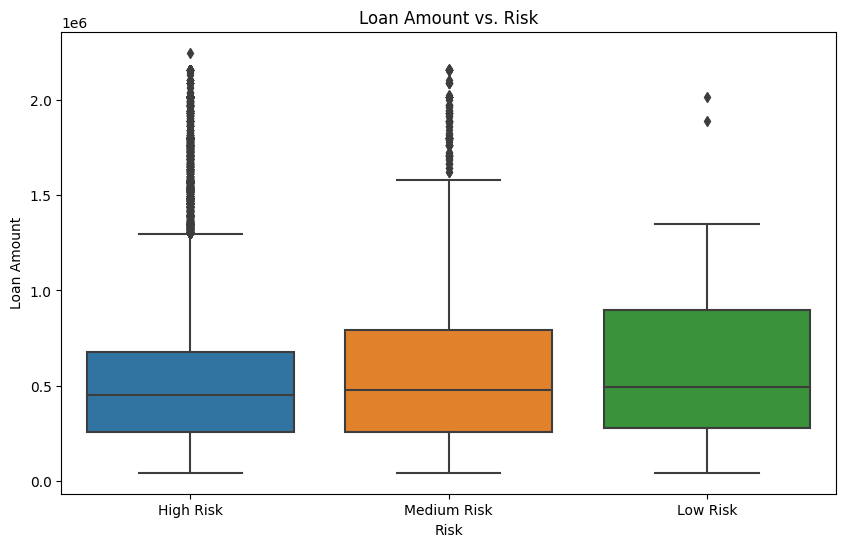

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Target_Category', y="AMT_CREDIT", data=combined_df)
plt.title("Loan Amount vs. Risk")
plt.xlabel("Risk")
plt.ylabel("Loan Amount")
plt.show()


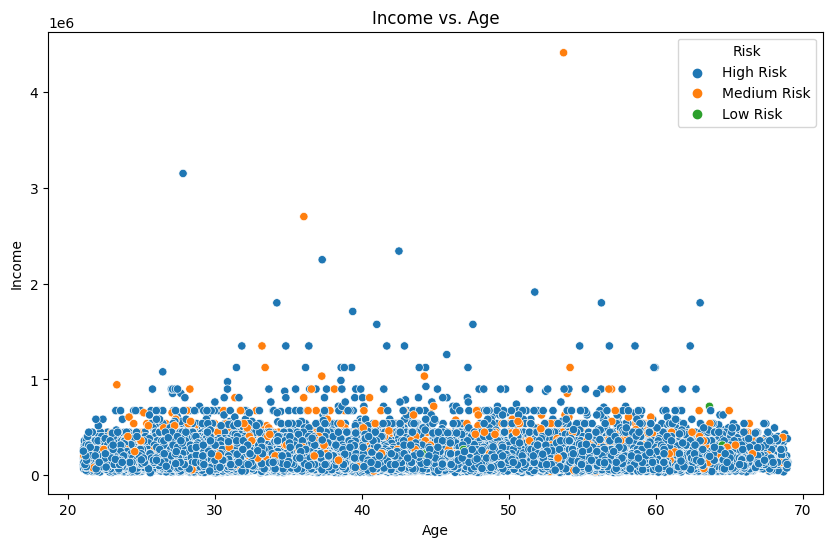

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=(df_train['DAYS_BIRTH']/-365), y="AMT_INCOME_TOTAL", hue='Target_Category', data=combined_df)
plt.title("Income vs. Age")
plt.xlabel("Age")
plt.ylabel("Income")
plt.legend(title="Risk")
plt.show()


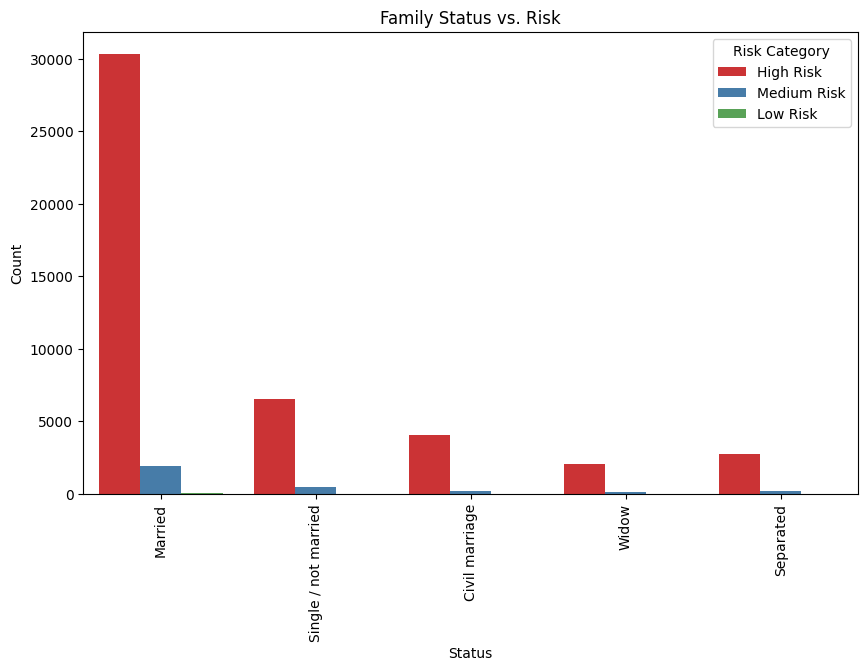

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df, x='NAME_FAMILY_STATUS', hue="Target_Category", palette='Set1')
plt.title("Family Status vs. Risk")
plt.xlabel("Status")
plt.ylabel("Count")
plt.legend(title="Risk Category")
plt.xticks(rotation=90)
plt.show()
